# Course Project

In this project, we investigate the relation between the average property prices and geometry location factors with in a city. Specifically, we crawl the property price for comunities in Beijing City from [Anjuke](https://beijing.anjuke.com/community), a famous online property trading giant, and combine them with positional information via [Baidu Map API](https://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding) to re-project them onto OpenStreetMap. We then investigate the influence on property prices from distances towards nearest important social facilities, e.g., school, hospital, metro station, with regression model. The result reveals a strong correlation between important location factors and nearby property price.

In [4]:
%load_ext autoreload
%autoreload 2

import osmnx as ox
import numpy as np
import geopandas as gpd
import pandana
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/miniconda3/envs/geospatial/share/proj failed


### 0. Prepare property price and location data
This may not run as expected because of anti-crawler, we already get the data ready:
- **price_community.txt**: name, year built and average price for communities, crawled from Anjuke.
- **position_price_community.txt**: the above plus position information (lat, lng), queried from Baidu Map API.

So NOT necessary to run the next block.

In [ ]:
# No need to run this block!
from community_price_crawler import crawl_community
crawl_community()

from location_api import locate_communities
locate_communities()

### 1. Load map of Beijing City

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


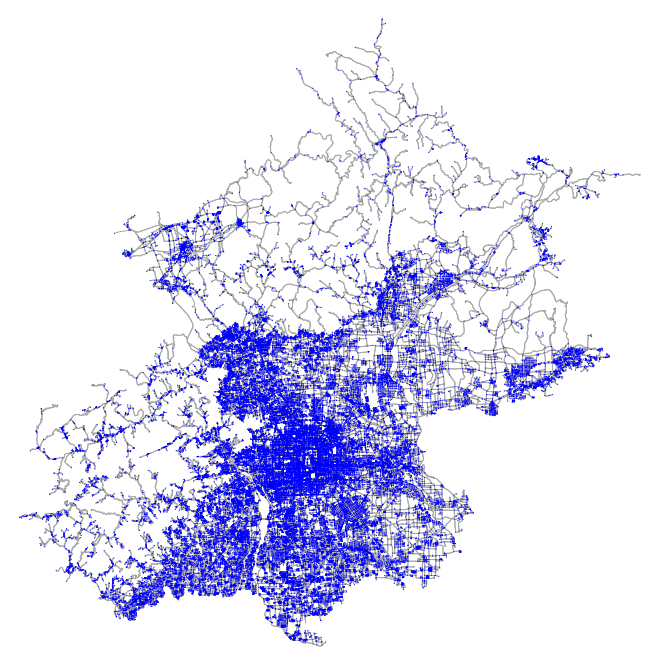

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [5]:
ox.config(log_console=False, use_cache=True)
G = ox.graph_from_place('Beijing', network_type='drive')
ox.plot_graph(G, bgcolor="w", node_size=1, node_color="blue", edge_color="#aaa", figsize=(12,12))

### 2. Pick all schools, hospitals, subway stations, malls and office buildings by tag filters

In [6]:
ox.config(log_console=False, use_cache=True)

def pick_by_tags(city, tags):
    results = ox.geometries_from_place(city, tags=tags)
    results = results[['name','geometry']]
    # filter out empty data  
    results = results[~(results['name'].isnull())]
    results = results[~(results['geometry'].isnull())]
    return results

In [7]:
# Pick schools
tag_school = {
    'amenity': ['school'],
       }
schools = pick_by_tags('Beijing', tag_school)
print(schools)

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestring

                                   name  \
element_type osmid                        
node         1719068845           人民村小学   
             1888180309    北京师范大学燕化附属中学   
             2735718007     北京市文化艺术职业学校   
             5439383394    北京石油化工学院教100   
             6296977835            信息学院   
...                                 ...   
way          685653398           延庆康庄中学   
             685653402          太平庄中心小学   
             907695696   张山营镇97.4音乐希望小学   
             958363386            张山营中学   
             958363393          姚家营中心小学   

                                                                  geometry  
element_type osmid                                                          
node         1719068845                         POINT (116.25030 39.84075)  
             1888180309                         POINT (115.96086 39.71993)  
             2735718007                         POINT (116.40202 39.83041)  
             5439383394                         POINT (

In [8]:
# Pick subway stations
tag_subway = {
    'subway': ['yes'],
       }
subways = pick_by_tags('Beijing', tags=tag_subway)
print(subways)

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


                            name                    geometry
element_type osmid                                          
node         340260427       宋家庄  POINT (116.42201 39.84439)
             528934416       角门西  POINT (116.36485 39.84440)
             528934756      公益西桥  POINT (116.36464 39.83527)
             1074413615       旧宫  POINT (116.45471 39.80561)
             1080681248   生物医药基地  POINT (116.31611 39.68511)
...                          ...                         ...
             9385028993      次渠北  POINT (116.57065 39.80864)
             9385028996      北神树  POINT (116.54715 39.81747)
             9385028997      北神树  POINT (116.54717 39.81757)
             9385042165      嘉会湖  POINT (116.60525 39.79180)
             6898636145  平谷站（在建）  POINT (117.09081 40.14867)

[1319 rows x 2 columns]


In [9]:
# Pick hospitals
tag_hospital = {
    'amenity': ['hospital'],
       }
hospitals = pick_by_tags('Beijing', tags=tag_hospital)
print(hospitals)

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestring

                                   name  \
element_type osmid                        
node         1889962824         房山区中医医院   
             2735718063           大红门医院   
             6282670487            良乡医院   
way          236355654            木材厂医院   
             312019427             旧宫医院   
...                                 ...   
             915309157     夏各庄镇社区卫生服务中心   
             970398918          平谷区中医医院   
             1060068294           金海湖医院   
             1040111161  北京京煤集团总医院木城涧医院   
             958363385     张山营镇社区卫生服务中心   

                                                                  geometry  
element_type osmid                                                          
node         1889962824                         POINT (115.95670 39.72090)  
             2735718063                         POINT (116.39988 39.83541)  
             6282670487                         POINT (116.13480 39.73524)  
way          236355654   POLYGON ((116.38809 39.83956, 

In [10]:
# Pick shopping malls and supermarkets
tag_mall = {
    'shop': ['mall'],
    'building': ['supermarket'],
       }
malls = pick_by_tags('Beijing', tags=tag_mall)
print(malls)

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestring

                                 name  \
element_type osmid                      
node         1889809894      华冠生活购物广场   
             1889809917        蓝腾购物中心   
             2866041901          鑫海鞋城   
             2866042101          红门鞋城   
             5281864638        Tianya   
...                               ...   
way          1040129961         红星美凯龙   
             1047621991        国泰谊宾商城   
             1052358595        国泰宏城卖场   
             1053608238  鑫海韵通大卖场（双兴店）   
relation     10947904          六佰本商业街   

                                                                  geometry  
element_type osmid                                                          
node         1889809894                         POINT (115.95524 39.72572)  
             1889809917                         POINT (115.95520 39.72525)  
             2866041901                         POINT (116.39542 39.83746)  
             2866042101                         POINT (116.39566 39.83815)  
    

In [11]:
# Pick office buildings
tag_office = {
    'building': ['office'],
       }
offices = pick_by_tags('Beijing', tags=tag_office)
print(offices)

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


                                              name  \
element_type osmid                                   
way          419999757                      中铁五院集团   
             432044726                      中铁建工集团   
             673209513                       学校办公楼   
             966362858                朝阳区人民法院第二办公区   
node         1655435413                 环境国际公约履约大楼   
...                                            ...   
way          1001557942  梨园派出所云景里社区警务工作室;梨园镇党群服务中心   
             1051193312                       33号楼   
             1055096810                    顺义粮油总公司   
             867009040                        晶能梦谷   
             980488329             延庆野鸭湖湿地自然保护区管理处   

                                                                  geometry  
element_type osmid                                                          
way          419999757   POLYGON ((116.33018 39.75727, 116.33120 39.757...  
             432044726   POLYGON ((116.29218 39.82774, 116.29245 3

In [207]:
print(f'Schools: \t {len(schools)}')
print(f'Subway stations: {len(subways)}')
print(f'Hospitals: \t {len(hospitals)}')
print(f'Malls: \t\t {len(malls)}')
print(f'Offices: \t {len(offices)}')

Schools: 	 1725
Subway stations: 1319
Hospitals: 	 346
Malls: 		 138
Offices: 	 140


### 3. Load community informations, and get corresponding nodes on the map 

In [274]:
communities = pd.read_csv("position_price_community.csv", sep=',')
communities["age"] = 2022 - communities["year"]
print(f'Number of communities: {len(communities["name"])}')
print(f'Example: {communities["name"][0]}, {communities["age"][0]}, {communities["price"][0]}, {communities["lat"][0]}, {communities["lng"][0]}')

Number of communities: 1316
Example: 万柳书院, 7, 179732, 39.97904727040592, 116.29949984829848


In [275]:
# Get nodes for each community
community_nodes = ox.distance.nearest_nodes(G, X=communities["lng"], Y=communities["lat"]) # X is longitude, Y is latitude
print(len(community_nodes))

1316


### 4. Count nearby facilities for each community node. 

In [25]:
# First get a Pandana graph
nodes,edges = ox.graph_to_gdfs(G,nodes=True,edges=True)
edges = edges.reset_index()
G_pan = pandana.Network(nodes['x'], nodes['y'], edges['u'], edges['v'], edges[['length']], twoway=False)

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 108606
Setting CH edge vector of size 267503
Range graph removed 209466 edges of 535006
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [267]:
def get_nodes(facilities):
    facilities['center'] = gpd.points_from_xy(
        x=facilities['geometry'].bounds[['minx','maxx']].mean(axis=1),
        y=facilities['geometry'].bounds[['miny','maxy']].mean(axis=1)
    )
    nodes = ox.distance.nearest_nodes(G,X=facilities['center'].x, Y=facilities['center'].y)
    return nodes
    
def count_by_threshold(nodes, target_node, threshold=3000.0):
    path_lengths = G_pan.shortest_path_lengths([target_node] * len(nodes), nodes)
    count = 0
    for length in path_lengths:
        count += 1 if length < threshold else 0
    return count

The following blocks could take a long time, so we already get the data ready:

In [268]:
# Count nearby schools
cnt_schools = []
nodes_school = get_nodes(schools)
for node in community_nodes:
    cnt_schools.append(count_by_threshold(nodes_school, node))

In [269]:
# Count nearby subway stations
cnt_subways = []
nodes_subway = get_nodes(subways)
for node in community_nodes:
    cnt_subways.append(count_by_threshold(nodes_subway, node))

In [270]:
# Count nearby hospitals
cnt_hospitals = []
nodes_hospital = get_nodes(hospitals)
for node in community_nodes:
    cnt_hospitals.append(count_by_threshold(nodes_hospital, node))

In [271]:
# Count nearby malls
cnt_malls = []
nodes_mall = get_nodes(malls)
for node in community_nodes:
    cnt_malls.append(count_by_threshold(nodes_mall, node))

In [272]:
# Count nearby offices
cnt_offices = []
nodes_office = get_nodes(offices)
for node in community_nodes:
    cnt_offices.append(count_by_threshold(nodes_office, node))

In [276]:
# Compute line-distance to Tiananmen Square
# Precise coordinate for Tiananmen Square is (39.90960456049752, 116.3972282409668)
lat_tam, lng_tam = [39.90960456049752] * len(communities["name"]), [116.3972282409668] * len(communities["name"])
lat_tam, lng_tam = np.array(lat_tam), np.array(lng_tam)

rad = 180 / 3.1415927
cos40 = np.cos(40 / rad)

communities["dist_tam"] = np.sqrt(((communities["lat"] - lat_tam) * 111) ** 2 
                                     + ((communities["lng"] - lng_tam) * 111 * cos40) ** 2)

print(communities[["name", "dist_tam"]])


      name   dist_tam
0     万柳书院  11.334482
1     紫玉山庄  12.227763
2     富成花园  10.606157
3     安宁佳园  17.214068
4     碧水庄园  25.387513
...    ...        ...
1311  纳帕尔湾  40.340395
1312  八角中里  15.899094
1313  三槐家园  16.520159
1314  紫成嘉园  16.287311
1315  正阳北里  10.540375

[1316 rows x 2 columns]


In [280]:
# Finally, complete community dataset
communities["cnt_school"] = np.array(cnt_schools)
communities["cnt_subway"] = np.array(cnt_subways)
communities["cnt_hospital"] = np.array(cnt_hospitals)
communities["cnt_mall"] = np.array(cnt_malls)
communities["cnt_office"] = np.array(cnt_offices)

communities.to_csv("complete_community_dataset.csv", index=False, sep=',')

### 5. Solve a linear regression model to predict property price

In [281]:
def normalize(data):
    ma, mi = np.max(data), np.min(data)
    k = 1 / (ma - mi)
    data = k * (data - mi)
    return data

In [282]:
# Load data from complete_community_dataset.csv and shuffle
data = pd.read_csv("complete_community_dataset.csv", sep=',')
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

        name  year   price        lat         lng  age   dist_tam  cnt_school  \
0  西山美墅馆(别墅)  2004  100697  39.960995  116.238451   18  14.656579           6   
1      石坊院小区  1991   41405  40.221476  116.243608   31  37.000191           4   
2       水墨林溪  2016   19378  39.694298  116.072322    6  36.529695           2   
3       力鸿花园  1998   93388  39.963021  116.448075   24   7.338194          20   
4       美林花园  2001  105977  39.952193  116.313441   21   8.550233          16   

   cnt_subway  cnt_hospital  cnt_mall  cnt_office  
0           0             1         0           0  
1           8             5         0           0  
2           3             0         0           0  
3          14             3         1           3  
4          19             2         2          15  


In [299]:
y_data, x_data = data["price"], data[["age", "cnt_school", "cnt_subway", "cnt_hospital", "cnt_mall", "cnt_office", "dist_tam"]]

# We normalize distances seperately since we consider different affects for each kind of factors
for col in x_data:
    x_data[col] = normalize(x_data[col])
    
# Normalize price
y_data = normalize(y_data)

# Add ones for theta0 in linear regression
x_data["constant"] = np.ones((x_data.shape[0], 1))
print(x_data.head())

        age  cnt_school  cnt_subway  cnt_hospital  cnt_mall  cnt_office  \
0  0.290323    0.100000    0.000000      0.066667  0.000000    0.000000   
1  0.500000    0.066667    0.129032      0.333333  0.000000    0.000000   
2  0.096774    0.033333    0.048387      0.000000  0.000000    0.000000   
3  0.387097    0.333333    0.225806      0.200000  0.083333    0.157895   
4  0.338710    0.266667    0.306452      0.133333  0.166667    0.789474   

   dist_tam  constant  
0  0.006804       1.0  
1  0.017859       1.0  
2  0.017626       1.0  
3  0.003183       1.0  
4  0.003783       1.0  


/tmp/ipykernel_31659/4084404416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[col] = normalize(x_data[col])
/tmp/ipykernel_31659/4084404416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data["constant"] = np.ones((x_data.shape[0], 1))


In [315]:
# Train-test split
train_ratio = 85
num_train = x_data.shape[0] * train_ratio // 100
x_train, x_test = x_data[0:num_train], x_data[num_train:]
y_train, y_test = y_data[0:num_train], y_data[num_train:]
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')

x_train.shape: (1118, 8)
y_train.shape: (1118,)


In [316]:
# Solve the leoblem
solve = np.linalg.lstsq(x_train, y_train, rcond=None)
print(solve)

(array([-0.01631948,  0.1360966 ,  0.22425608,  0.17480847, -0.02552023,
        0.18505962, -0.10197246,  0.31494573]), array([36.79282228]), 8, array([37.07829512, 10.39480357,  4.61663965,  4.33601539,  3.87858533,
        3.63032743,  2.43919549,  1.70739189]))


### 6. Test the linear regression model

Final MSE: 0.03226583798253192
[[1.         0.52704476]
 [0.52704476 1.        ]]


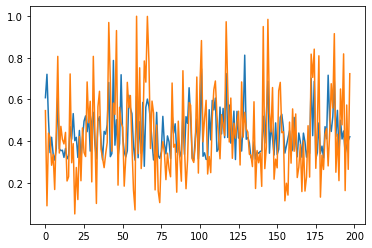

In [318]:
MSE = 0.
y_preds = []
for i in range(x_test.shape[0]):
    y_preds.append(x_test.iloc[i].dot(solve[0]))
    MSE += (y_preds[-1] - y_test.iloc[i]) ** 2
MSE /= x_test.shape[0]
print(f'Final MSE: {MSE}')

plt.plot(range(len(y_preds)), y_preds)
plt.plot(range(y_test.shape[0]), y_test)

print(np.corrcoef(y_preds, y_test))

### 7. Conclusion
The testing result shows a medium degree of correlation with r-value 0.52 in \[0.5, 0.8\], between predicted value **price** and predictive variables, indicating a strong influence of livelihood factors (school, subway, hospital, etc.) to property prices in Beijing.   
However, we also notice these factors are not entirely relevent, or decisive to property price. We consider following possible explanations:
- **The inner differences between specific facilities**. For example, the schools with different ranks and subway stations on different lines could be different in terms of influence on prices.
- **Other factors we did not / could not incorporate**. There could be case-by-case factors which are less general, e.g., policy, history, reputation.
- **LR model may not be strong enough to learn the intrinsic correlation**.